In [1205]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from bcb import sgs

In [1206]:
ativos = ["BTC-USD"]
df = yf.download(ativos, start="2015-01-01")
dfs = yf.download('^GSPC', start="2015-01-01")
df["retorno"] = df["Close"].pct_change()
# df["retorno shifted"] = df["Close"].pct_change().shift(-1)
dfs["retorno"] = dfs["Adj Close"].pct_change()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [1207]:
df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

In [1208]:
cdi = sgs.get({'CDI':12}, start='1970-01-01')
ipca = sgs.get({'IPCA':433}, start='2005-01-01')

In [1209]:
df["ipca"] = ipca
df["ipca"] = df["ipca"].fillna(0)
valor = None
for i in range(len(df)):
    if(df["ipca"].iloc[i] != 0):
        valor = df["ipca"].iloc[i]
    elif(df["ipca"].iloc[i] == 0):
        df["ipca"].iloc[i] = valor 

c:\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [1210]:
df["cdi"] = cdi/100

In [1211]:
df = df.dropna()

In [1212]:
vetor = list([])
for i in range(len(df)):
    if (i == len(df)):
        vetor.append(0)
    elif (df["Adj Close"].iloc[i]  <  df["Adj Close"].iloc[i-1]):
        vetor.append(0)
    elif (df["Adj Close"].iloc[i]  >  df["Adj Close"].iloc[i-1]): 
        vetor.append(1)
    else:
        vetor.append(0)

In [1213]:
df["signal"] = vetor

In [1214]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# df_norm = scaler.fit_transform(df)
# df_norm = pd.DataFrame(df_norm)
# df_norm.columns = df.columns
# df_norm = df_norm.set_index(df.index)
# df = df_norm


In [1215]:
Y = df[df.index < "2022-01-01"]["signal"]
X = df[df.index < "2022-01-01"].loc[:, (df.columns != "signal")&(df.columns != "retorno")]

X = pd.DataFrame(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [1216]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
predictrftest = rf.predict(x_test)
print(classification_report(y_test, predictrftest))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       244
           1       0.68      0.73      0.71       283

    accuracy                           0.67       527
   macro avg       0.67      0.67      0.67       527
weighted avg       0.67      0.67      0.67       527



c:\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


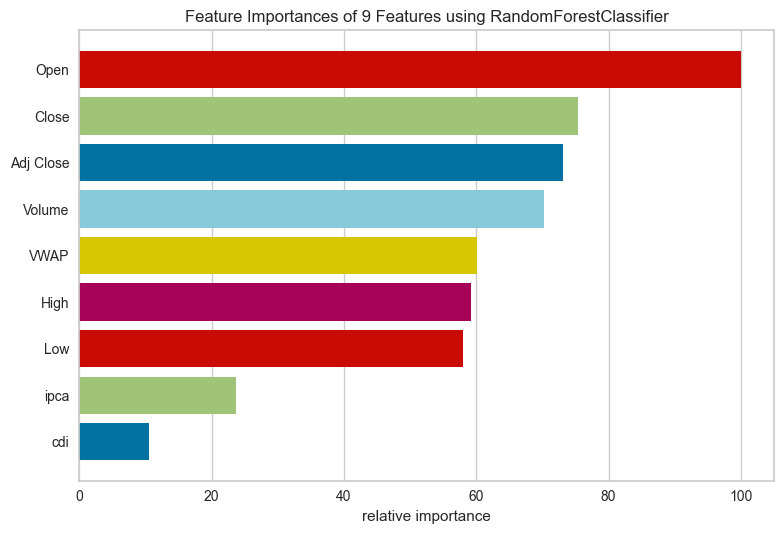

<AxesSubplot:title={'center':'Feature Importances of 9 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [1217]:
viz = FeatureImportances(rf)
fig, ax = plt.subplots()
viz = FeatureImportances(rf, relative=True) 
viz.fit(x_train, y_train)
viz.poof()

In [1218]:
df_aux = df[df.index >= "2022-01-01"]
dfs_aux = dfs[dfs.index >= '2022-01-01']

In [1219]:
K = df_aux["signal"]
Z = df_aux.loc[:, (df.columns != "signal")&(df.columns != "retorno")]

In [1220]:
df_aux["sinal modelo"] = rf.predict(Z)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1221]:
df_aux["sinal modelo"].value_counts()

1    246
0    167
Name: sinal modelo, dtype: int64

In [1222]:
rent = list([])
for i in range(len(df_aux)):
    if (df_aux["sinal modelo"].iloc[i-1] == 1):
        rent.append(df_aux["retorno"].iloc[i] - 0.00009)
    elif (df_aux["sinal modelo"].iloc[i-1] == 0):
        rent.append(-df_aux["retorno"].iloc[i]-0.00018)



In [1223]:
df_aux["retorno estrategia"] = rent

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


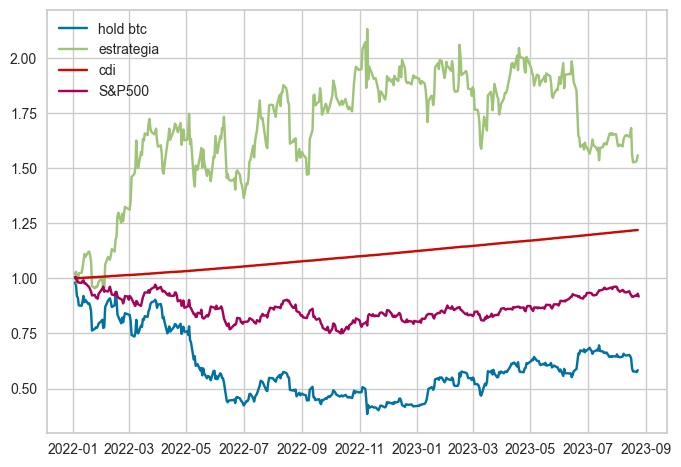

In [1224]:
plt.plot(df_aux.index, (df_aux["retorno"]+1).cumprod(), label="hold btc")
plt.plot(df_aux.index, (df_aux["retorno estrategia"]+1).cumprod(), label="estrategia")
plt.plot(df_aux.index, (df_aux["cdi"]+1).cumprod(), label='cdi')
plt.plot((dfs_aux["retorno"]+1).cumprod(), label='S&P500')
plt.legend()



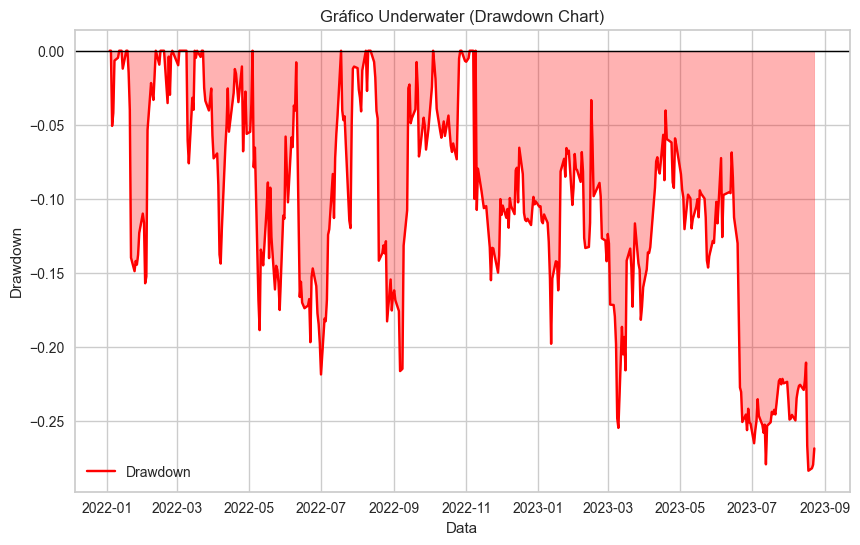

In [1225]:
rolling_max = (df_aux['retorno estrategia']+1).cumprod().cummax()
drawdown = ((df_aux['retorno estrategia']+1).cumprod() / rolling_max)  -1

# Plotar o gráfico Underwater
plt.figure(figsize=(10, 6))
plt.plot(df_aux.index, drawdown, color='red', label='Drawdown')
plt.fill_between(df_aux.index, drawdown, color='red', alpha=0.3)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.title('Gráfico Underwater (Drawdown Chart)')
plt.legend()
plt.grid(True)
plt.show()

In [1226]:
df_aux["excessos retorno"] = df_aux["retorno estrategia"] - df_aux["cdi"]
sharpe_ratio_diario = df_aux["excessos retorno"].mean() / df_aux["excessos retorno"].std()
sharpe_ratio_diario

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.034530022408545503

In [1227]:
# Calcular o beta
covariance = np.cov((df_aux['retorno estrategia']-df_aux["cdi"]), (df_aux['retorno'] - df_aux['cdi']))[0][1]
variance_market = np.var(df_aux['retorno']-df_aux['cdi'])

beta = covariance / variance_market

print("Beta da estratégia em relação ao BTC:", beta)

Beta da estratégia em relação ao BTC: 0.38418302349048017


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  4.,  2.,  3.,  3.,  2.,  3.,  0.,
         5.,  2.,  4.,  8.,  8., 11., 12.,  9., 15., 14., 24., 25., 29.,
        22., 27., 18., 20., 12., 18., 11., 13.,  6., 10., 11., 10.,  5.,
         3.,  2.,  5.,  5.,  3.,  3.,  1.,  0.,  2.,  1.,  0.,  0.,  1.,
         4.,  1.,  1.,  0.,  1.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.15983726, -0.15680579, -0.15377431, -0.15074284, -0.14771136,
        -0.14467989, -0.14164841, -0.13861694, -0.13558546, -0.13255399,
        -0.12952251, -0.12649104, -0.12345956, -0.12042809, -0.11739661,
        -0.11436514, -0.11133366, -0.10830219, -0.10527071, -0.10223924,
        -0.09920776, -0.09617629, -0.09314481, -0.09011334, -0.08708186,
        -0.08405039, -0.08101891, -0.07798744, -0.07495596, -0.071924

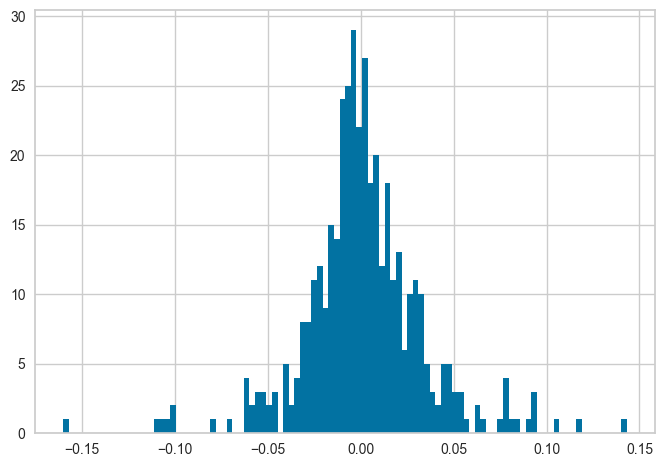

In [1228]:
plt.hist(df_aux["retorno estrategia"], bins=100)

In [1229]:
bin_edges = np.histogram_bin_edges(df_aux["retorno estrategia"], bins=50)
hist = np.histogram(df_aux["retorno estrategia"])
bin_edges
hist

(array([  1,   5,   2,  22, 107, 195,  60,  13,   6,   2], dtype=int64),
 array([-0.15983726, -0.12952251, -0.09920776, -0.06889301, -0.03857827,
        -0.00826352,  0.02205123,  0.05236598,  0.08268073,  0.11299548,
         0.14331022]))

In [1230]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno estrategia"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin a partir do qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à direita do valor de referência
observacoes_direita = sum(hist[indice_bin_referencia:])

print(f"Observações à direita de {valor_referencia}: {observacoes_direita}")


Observações à direita de 0: 173


In [1231]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno estrategia"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin até o qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à esquerda do valor de referência
observacoes_esquerda = sum(hist[:indice_bin_referencia])

print(f"Observações à esquerda de {valor_referencia}: {observacoes_esquerda}")


Observações à esquerda de 0: 240


In [1232]:
# Separar retornos positivos e negativos
retornos_positivos = df_aux[df_aux['retorno estrategia'] > 0]['retorno estrategia']

retornos_negativos = df_aux[df_aux['retorno estrategia'] < 0]['retorno estrategia']

# Calcular a diferença entre os retornos positivos e negativos
diferenca_retornos = np.sum(retornos_positivos) + np.sum(retornos_negativos)

print(f"Diferença entre retornos positivos e negativos: {diferenca_retornos}")

Diferença entre retornos positivos e negativos: 0.6630041365125958


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  3.,  0.,  0.,  1.,  1.,  1.,  4.,  1.,  2.,  0.,
         5.,  2.,  2.,  2.,  2.,  4.,  6., 12.,  6.,  9.,  9., 11.,  8.,
        13., 14., 26., 23., 25., 22., 17., 25., 18.,  9., 15., 14., 14.,
        10.,  7., 12.,  5.,  6.,  3.,  3.,  4.,  1.,  6.,  3.,  3.,  4.,
         1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
         2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([-0.15974726, -0.15698001, -0.15421275, -0.1514455 , -0.14867825,
        -0.14591099, -0.14314374, -0.14037649, -0.13760923, -0.13484198,
        -0.13207473, -0.12930747, -0.12654022, -0.12377297, -0.12100571,
        -0.11823846, -0.11547121, -0.11270395, -0.1099367 , -0.10716945,
        -0.1044022 , -0.10163494, -0.09886769, -0.09610044, -0.09333318,
        -0.09056593, -0.08779868, -0.08503142, -0.08226417, -0.079496

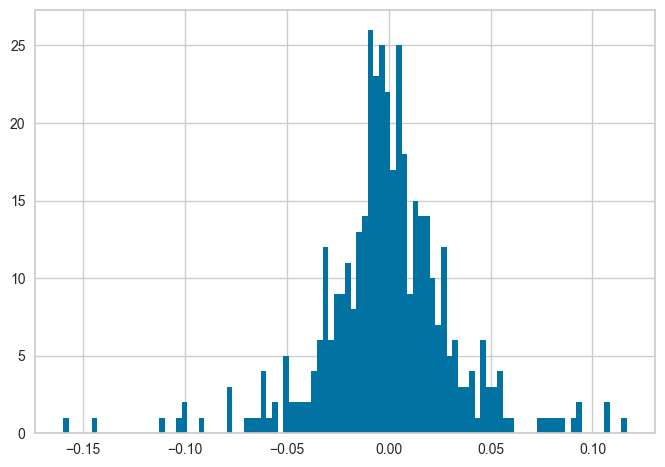

In [1233]:
plt.hist(df_aux["retorno"],bins=100)

In [1234]:
bin_edges = np.histogram_bin_edges(df_aux["retorno"], bins=50)
hist = np.histogram(df_aux["retorno"])
bin_edges
hist

(array([  2,   1,   7,  15,  54, 184, 110,  29,   5,   6], dtype=int64),
 array([-0.15974726, -0.13207473, -0.1044022 , -0.07672966, -0.04905713,
        -0.0213846 ,  0.00628794,  0.03396047,  0.061633  ,  0.08930553,
         0.11697807]))

In [1235]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin a partir do qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à direita do valor de referência
observacoes_direita = sum(hist[indice_bin_referencia:])

print(f"Observações à direita de {valor_referencia}: {observacoes_direita}")


Observações à direita de 0: 192


In [1236]:
# Seus dados de retorno de estratégia
retorno_estrategia = df_aux["retorno"]

# Calculando os bin edges
bin_edges = np.histogram_bin_edges(retorno_estrategia, bins=50)

# Calculando o histograma
hist, _ = np.histogram(retorno_estrategia, bins=bin_edges)

# Valor a partir do qual você quer contar
valor_referencia = 0

# Encontre o índice do bin até o qual você deseja contar
indice_bin_referencia = next(idx for idx, edge in enumerate(bin_edges) if edge > valor_referencia)

# Conte as observações nos bins à esquerda do valor de referência
observacoes_esquerda = sum(hist[:indice_bin_referencia])

print(f"Observações à esquerda de {valor_referencia}: {observacoes_esquerda}")

Observações à esquerda de 0: 221


In [1237]:
# Separar retornos positivos e negativos
retornos_positivos = df_aux[df_aux['retorno'] > 0]['retorno']

retornos_negativos = df_aux[df_aux['retorno'] < 0]['retorno']

# Calcular a diferença entre os retornos positivos e negativos
diferenca_retornos = np.sum(retornos_positivos) + np.sum(retornos_negativos)

print(f"Diferença entre retornos positivos e negativos: {diferenca_retornos}")

Diferença entre retornos positivos e negativos: -0.31717949276585955


In [1238]:
# Calcular o alfa
average_return_btc = df_aux['retorno estrategia']
average_return_market = df_aux['retorno']
alpha = np.mean(average_return_btc) - beta * np.mean(average_return_market)

print("Alfa da estratégia em relação ao BTC-USD:", alpha)

Alfa da estratégia em relação ao BTC-USD: 0.001900385261580048
